# Unsupervised Learning & Advanced ML Techniques

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## Data Loading and Exploratory Data Analysis (EDA)
We will load the **Mall Customer** dataset from Kaggle and perform an exploratory data analysis (EDA) to understand the distributions of the main numerical features (`Age`, `Annual Income (k$)`, and `Spending Score (1-100)`) as well as the composition of the categorical feature (`Gender`).


In [40]:
# Load Dataset
url = "Mall_Customers.csv"  # make sure the file is in the same directory or change path
df = pd.read_csv(url)

# Show first rows
print("First 5 rows of dataset:")
df.head()

# Dataset Info
print("\nDataset Info:")
print(df.info())

# Dataset Description
print("\nStatistical Summary:")
print(df.describe())


First 5 rows of dataset:

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

Statistical Summary:
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.50

## Exploratory Data Analysis (EDA)

We will perform an exploratory data analysis (EDA) to understand the distributions of the main numerical features (`Age`, `Annual Income (k$)`, and `Spending Score (1-100)`) as well as the composition of the categorical feature (`Gender`).


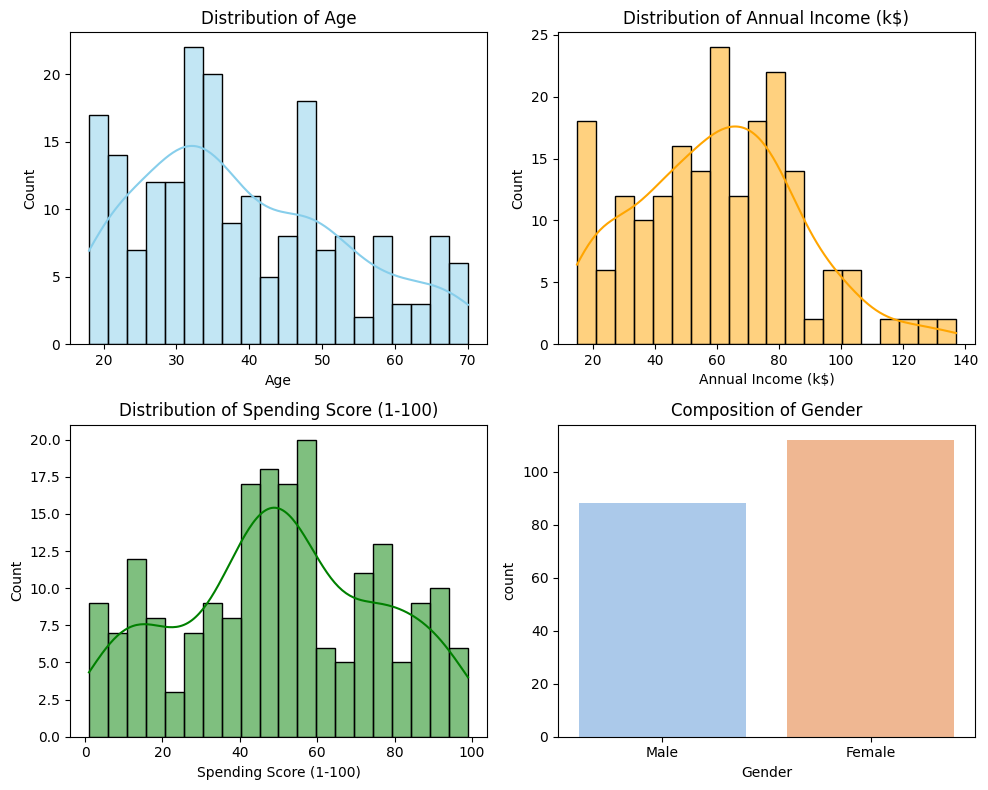

In [52]:

# Exploratory Data Analysis (EDA)
# Subplots 2x2
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Distribution of Age
sns.histplot(df['Age'], bins=20, kde=True, color='skyblue', ax=axes[0,0])
axes[0,0].set_title('Distribution of Age')

# Distribution of Annual Income
sns.histplot(df['Annual Income (k$)'], bins=20, kde=True, color='orange', ax=axes[0,1])
axes[0,1].set_title('Distribution of Annual Income (k$)')

# Distribution of Spending Score
sns.histplot(df['Spending Score (1-100)'], bins=20, kde=True, color='green', ax=axes[1,0])
axes[1,0].set_title('Distribution of Spending Score (1-100)')

# Gender Composition
sns.countplot(x='Gender', hue='Gender', data=df, palette='pastel', legend=False, ax=axes[1,1])
axes[1,1].set_title('Composition of Gender')

# Layout biar nggak tabrakan
plt.tight_layout()
plt.savefig('EDA_plots.png', dpi=300)
plt.show()




### Summary of Initial EDA
The Mall Customer dataset consists of both numerical and categorical features. After inspecting the dataset, the following decisions were made:

The dataset includes a **CustomerID** column, which is purely an identifier and has no predictive value, so it was dropped.  
The remaining features provide useful information for clustering and analysis:
- **Numerical features:** `Age`, `Annual Income (k$)`, `Spending Score (1-100)`  
- **Categorical feature:** `Gender`  

Exploratory Data Analysis (EDA) revealed the following patterns:
1. **Age Distribution** → Most customers are young to middle-aged adults, with a concentration between 20 and 40 years old.  
2. **Annual Income Distribution** → Income values are fairly evenly spread, with some concentration around the mid-range (40–70k$).  
3. **Spending Score Distribution** → Customers display a wide spread, with groups showing both high and low spending scores regardless of income.  
4. **Gender Composition** → The dataset contains both male and female customers, with a slightly larger proportion of females.  

This analysis highlights which features are relevant for clustering.  
- `Age`, `Annual Income (k$)`, and `Spending Score (1-100)` provide continuous variation useful for defining customer groups.  
- `Gender` may contribute additional categorical differentiation, though it is less directly linked to spending or income compared to the numerical features.  

---
The EDA shows potential for meaningful segmentation of customers into distinct groups, which can later be confirmed using clustering algorithms. It also emphasizes the importance of preprocessing, such as **scaling numerical features** and **encoding categorical variables**, before applying machine learning methods.

## Full Preprocessing
We will prepare the dataset for analysis by:
1. Dropping `CustomerID` since it is just an identifier.
2. Applying One-Hot Encoding on the `Gender` feature (`drop_first=True` to avoid multicollinearity).
3. Scaling all numerical features using `StandardScaler`.
4. Combining the encoded categorical feature and scaled numerical features into one fully preprocessed dataset.

In [42]:
# Drop CustomerID
df_prep = df.drop("CustomerID", axis=1)

# One-Hot Encode Gender
df_encoded = pd.get_dummies(df_prep, columns=["Gender"], drop_first=True)

# Separate numerical and categorical
numerical_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
categorical_features = [col for col in df_encoded.columns if col not in numerical_features]

# Scale numerical features
scaler = StandardScaler()
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

# Final preprocessed dataset
print("\nFinal Preprocessed Dataset:")
display(df_encoded.head())

# Convert to NumPy array if needed
X = df_encoded.values
print("\nShape of preprocessed dataset:", X.shape)



Final Preprocessed Dataset:


,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,-1.424569,-1.738999,-0.434801,True
1,-1.281035,-1.738999,1.195704,True
2,-1.352802,-1.700830,-1.715913,False
3,-1.137502,-1.700830,1.040418,False
4,-0.563369,-1.662660,-0.395980,False



Shape of preprocessed dataset: (200, 4)


## Clustering on High-Dimensional Data

### Optimal K Selection
#### We need to determine the optimal number of clusters (K) using two methods:
1. `Elbow Method`: Plot the Within-Cluster Sum of Squares (WCSS) for K = 1 to 10.
2. `Silhouette Score`: Evaluate clustering quality for K = 2 to 10.
#### This ensures that the selected K balances compact clusters and clear separation.

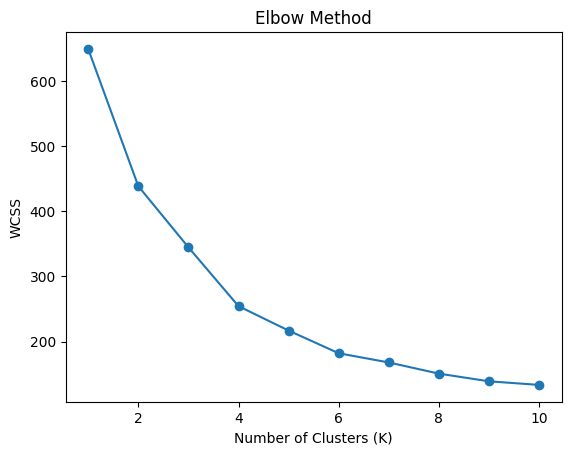

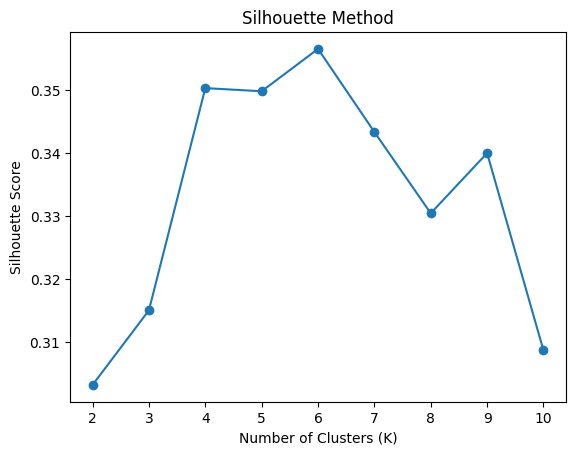

In [43]:

# Assume X is the fully preprocessed high-dimensional dataset
wcss = []
silhouette_scores = []

K_range = range(2, 11)

# Elbow method
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Silhouette method
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

# Plot Elbow
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.savefig('Elbow_Method.png', dpi=300)
plt.show()

# Plot Silhouette
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.savefig('Silhouette_Method.png', dpi=300)
plt.show()


### K-Means Modeling
After selecting the optimal K (based on the above results), we train the KMeans model.

In [44]:
optimal_k = 5  # example, choose based on plots
kmeans_highdim = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
labels_highdim = kmeans_highdim.fit_predict(X)


### Evaluation
We compute the Silhouette Score to measure clustering quality.

In [45]:
sil_score_highdim = silhouette_score(X, labels_highdim)
print("Silhouette Score (High-Dimensional Data):", sil_score_highdim)

Silhouette Score (High-Dimensional Data): 0.34977050035201074


## Clustering After Dimensionality Reduction (PCA)

### Apply PCA
We reduce dimensionality with PCA, keeping at least 90% variance.

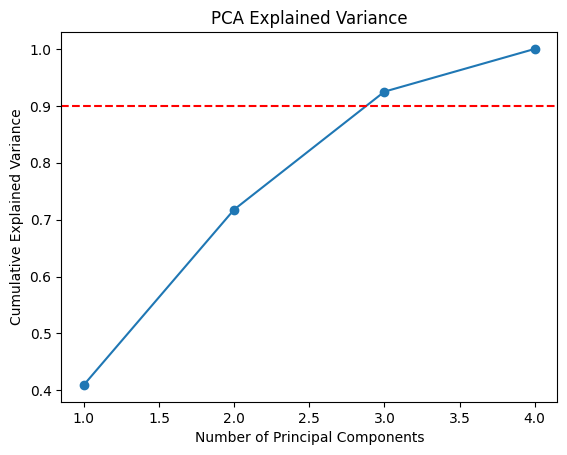

Number of components for >=90% variance: 3


In [46]:
pca = PCA()
X_pca = pca.fit_transform(X)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.savefig('PCA_Explained_Variance.png', dpi=300)
plt.show()

# Minimum number of components for 90% variance
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
print("Number of components for >=90% variance:", n_components_90)

### Data Transformation

In [47]:
pca = PCA(n_components=n_components_90)
X_reduced = pca.fit_transform(X)

### K-Means on PCA Data
Repeat the same optimal K selection process.

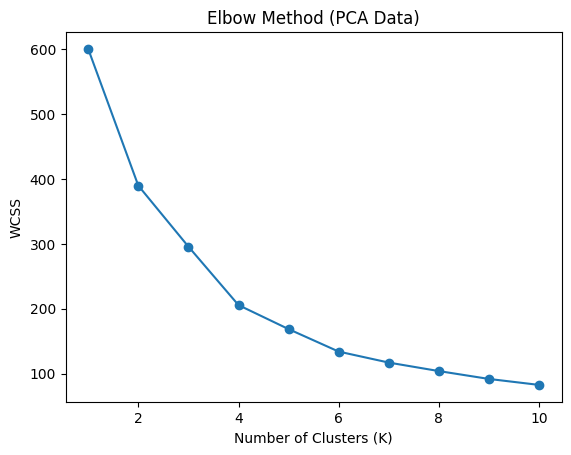

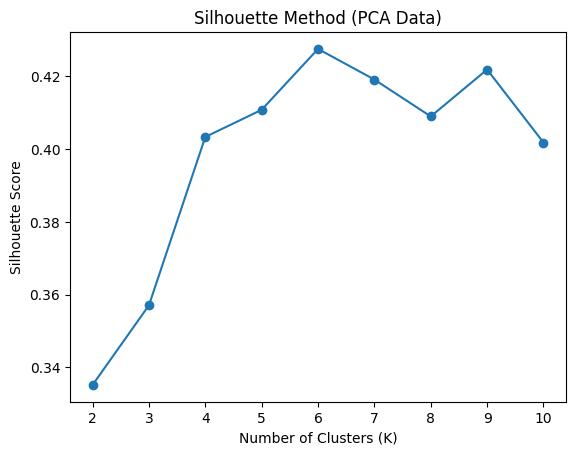

Silhouette Score (PCA Data): 0.4107985025553045


In [48]:
# Elbow Method (PCA data)
wcss_pca = []
silhouette_pca = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_reduced)
    wcss_pca.append(kmeans.inertia_)

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_reduced)
    silhouette_pca.append(silhouette_score(X_reduced, labels))

# Plot Elbow
plt.plot(range(1, 11), wcss_pca, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method (PCA Data)")
plt.savefig('Elbow_Method_PCA.png', dpi=300)
plt.show()

# Plot Silhouette
plt.plot(range(2, 11), silhouette_pca, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method (PCA Data)")
plt.savefig('Silhouette_Method_PCA.png', dpi=300)
plt.show()

# Final Model
optimal_k_pca = 5  # example, choose based on plots
kmeans_pca = KMeans(n_clusters=optimal_k_pca, n_init=10, random_state=42)
labels_pca = kmeans_pca.fit_predict(X_reduced)

# Evaluation
sil_score_pca = silhouette_score(X_reduced, labels_pca)
print("Silhouette Score (PCA Data):", sil_score_pca)


## Comparative Analysis and Segment Profiling

### Visualize and Compare Clusters

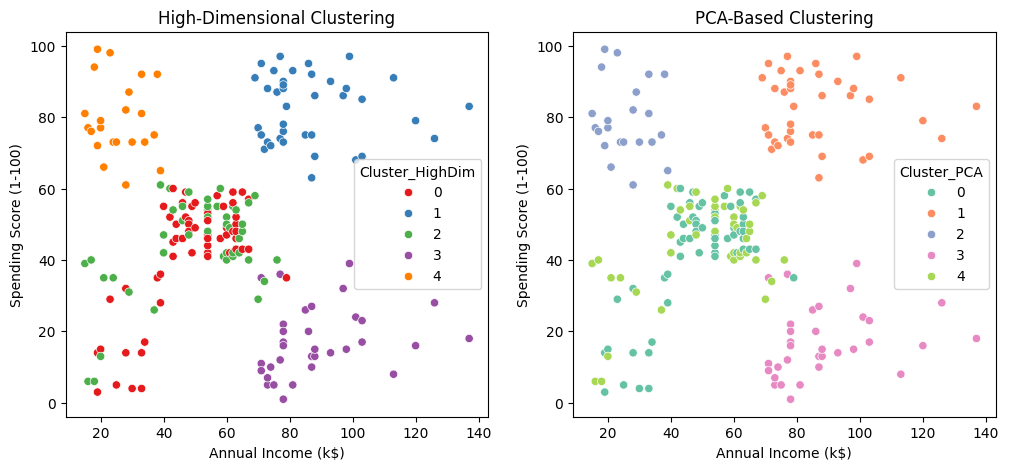

In [51]:
# Add cluster labels to DataFrame
df['Cluster_HighDim'] = labels_highdim
df['Cluster_PCA'] = labels_pca

# Side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Cluster_HighDim', data=df, palette='Set1', ax=axes[0])
axes[0].set_title("High-Dimensional Clustering")

sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Cluster_PCA', data=df, palette='Set2', ax=axes[1])
axes[1].set_title("PCA-Based Clustering")

plt.savefig('Clustering_Comparison.png', dpi=300)
plt.show()



### Customer Segment Profiling

In [50]:
# Choose better clustering result (example: PCA-based)
chosen = 'Cluster_PCA'

# Group by cluster
profiles = df.groupby(chosen)[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()
print(profiles)

# Example persona assignment
personas = {
    0: "Young Target Audience",
    1: "Careful High-Earners",
    2: "Budget-Conscious Shoppers",
    3: "Luxury Enthusiasts",
    4: "Average Middle Class"
}


                   Age  Annual Income (k$)  Spending Score (1-100)
Cluster_PCA                                                       
0            55.551724           48.482759               41.775862
1            32.692308           86.538462               82.128205
2            25.272727           25.727273               79.363636
3            41.264706           88.500000               16.764706
4            27.957447           50.000000               44.638298
